# ResNet50 Transfer Learning & Model Training of bottom 5 layers
5 epochs


In [1]:
import boto3, re
from sagemaker import get_execution_role
role = get_execution_role()

In [2]:
import tensorflow
print(tensorflow.__version__)


1.15.2


In [3]:
!pip install pydicom

You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
!pip install mlxtend  

You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tensorflow.keras.utils import Sequence
import math
import pydicom
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
import seaborn as sns
from pydicom import dcmread
from pydicom.filebase import DicomBytesIO
import cv2
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import time

In [6]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

# **Load Dicom images**

In [7]:
root_path = 'sagemaker-capstone-pd'
train_dicom_dir = 'pneumonia-dataset/stage_2_train_images/'
train_lables_filename = 'pneumonia-dataset/stage_2_train_labels.csv'


In [8]:
def load_csv_file(path, filename):
  bucket = path
  data_key = filename
  data_location = 's3://{}/{}'.format(bucket, data_key) 
  train_labels_df = pd.read_csv(data_location)
  return train_labels_df

In [9]:
training_data = load_csv_file(root_path,train_lables_filename )

In [10]:
print(training_data.shape)

(30227, 6)


In [11]:
training_data.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [12]:
training_imgs = ["{}.dcm".format(x) for x in list(training_data.patientId)]

In [13]:
print(training_imgs[:5])

['0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm', '00313ee0-9eaa-42f4-b0ab-c148ed3241cd.dcm', '00322d4d-1c29-4943-afc9-b6754be640eb.dcm', '003d8fa0-6bf1-40ed-b54c-ac657f8495c5.dcm', '00436515-870c-4b36-a041-de91049b9ab4.dcm']


In [14]:
training_labels_1 = list(training_data['Target'])

In [15]:
print(training_labels_1[:5])

[0, 0, 0, 0, 1]


In [16]:
training_data_1 = pd.DataFrame( {'Images': training_imgs,'Target': training_labels_1})


In [17]:
training_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
Images    30227 non-null object
Target    30227 non-null int64
dtypes: int64(1), object(1)
memory usage: 472.4+ KB


In [18]:
training_data_1.head()

,Images,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd.dcm,0
2,00322d4d-1c29-4943-afc9-b6754be640eb.dcm,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5.dcm,0
4,00436515-870c-4b36-a041-de91049b9ab4.dcm,1


In [19]:
from sklearn.model_selection import train_test_split

# Sort the rows of dataframe by column 'Images'
training_data_1 = training_data_1.sort_values(by ='Images', ascending=True )
#temp_df = training_data_1.iloc[:100] use only for testing
temp_df = training_data_1
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30227 entries, 0 to 28988
Data columns (total 2 columns):
Images    30227 non-null object
Target    30227 non-null int64
dtypes: int64(1), object(1)
memory usage: 708.4+ KB


In [20]:
training_set = pd.DataFrame()
validation_set = pd.DataFrame()

training_set, validation_set = train_test_split(temp_df, random_state = 0, test_size = 0.2)

In [21]:
training_set.reset_index(inplace = True)
validation_set.reset_index(inplace = True)

print(training_set.info())
print(validation_set.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24181 entries, 0 to 24180
Data columns (total 3 columns):
index     24181 non-null int64
Images    24181 non-null object
Target    24181 non-null int64
dtypes: int64(2), object(1)
memory usage: 566.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6046 entries, 0 to 6045
Data columns (total 3 columns):
index     6046 non-null int64
Images    6046 non-null object
Target    6046 non-null int64
dtypes: int64(2), object(1)
memory usage: 141.8+ KB
None


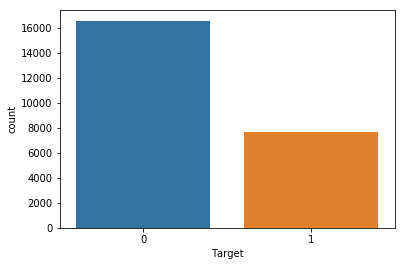

In [22]:
ax = sns.countplot(x="Target", data=training_set)

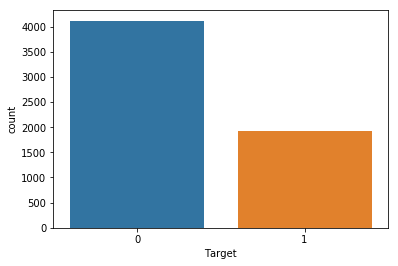

In [23]:
ax = sns.countplot(x="Target", data=validation_set)

In [24]:
training_set.head()

,index,Images,Target
0,5846,4a21a2af-8822-43aa-9dcd-6b412dcb3d43.dcm,0
1,27577,f4d92d38-4a58-45d4-a5a3-dd83772e51bc.dcm,0
2,22291,c9b3c7ce-4f39-4702-8206-2903d27afa9c.dcm,0
3,16384,9ea49ec4-2b4f-4e7b-94f1-99ba8d10a629.dcm,0
4,10849,7245635f-de15-4117-9069-e39743d9da2f.dcm,0


In [25]:
IMAGE_SIZE = 224
BATCH_SIZE = 50
EPOCHS = 5 # Number of epochs.
PATIENCE = 2 # Patience for early stopping
MULTI_PROCESSING = True 
THREADS = 1
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

In [26]:
# Training Data Generator

class DataGen(Sequence):
    def __init__(self, data_df):
        self.paths = []
        df_len = len(data_df)
        self.pneumonia_calss = np.zeros((df_len,2))
        for index, row in data_df.iterrows():
          #print(index)
          path = row['Images']
          classes = row['Target']
          self.paths.append(path) # Read image from here
          #self.pneumonia_calss.append(classes) # Read target from here
          if classes == 1:
            self.pneumonia_calss[index, 0] = 1
            self.pneumonia_calss[index, 1] = 0
          else:
            self.pneumonia_calss[index, 0] = 0
            self.pneumonia_calss[index, 1] = 1
        

    def __len__(self):
        return math.ceil(len(self.pneumonia_calss) / BATCH_SIZE)

    def __getitem__(self, idx): # Get a batch
        batch_paths = self.paths[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE] # Image path
        batch_coords = self.pneumonia_calss[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE] # Image coords

        batch_images = np.zeros((len(batch_paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
        session = boto3.Session()
        s3_session = session.client('s3')
        for i, f in enumerate(batch_paths):
            
            f = train_dicom_dir +  f
            #print('file for loading ',  f)
            fileobj = s3_session.get_object(Bucket=root_path,  Key=f )
            dicom_data = fileobj['Body'].read()
            dicom_bytes = DicomBytesIO(dicom_data)
            c_dicom = dcmread(dicom_bytes) 
            image = c_dicom.pixel_array
            # If grayscale. Convert to RGB for consistency.
            if len(image.shape) != 3 or image.shape[2] != 3: 
                img = np.stack((image,) * 3, -1)
 
            dim = (IMAGE_SIZE, IMAGE_SIZE)
            img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
            #print(' File ', f, ' img shape ', img.shape )
            batch_images[i] = preprocess_input(np.array(img, dtype=np.float32)) # Convert to float32 array
            #print('batch_coords' , batch_coords)
            
        return batch_images, batch_coords

In [27]:
train_dataGen  = DataGen(training_set)
validation_datagen = DataGen(validation_set)

In [28]:
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [29]:
base_model.trainable = True
for layer in base_model.layers[:-5]:
    layer.trainable = False

for layer in base_model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f534d9b7748> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f53a52319b0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f534d9d4390> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7f534d9d4cc0> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f534d99f1d0> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f534d9d4cf8> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f534d955b70> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f534d8f5ac8> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7f534d91d550> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f534d8b6358> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f534d91d6d8> False
<tensorflow.python.keras.layers.nor

In [31]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [32]:
model = tf.keras.Sequential([
                          base_model,
                          keras.layers.GlobalAveragePooling2D(),
                          keras.layers.Dense(2, activation='sigmoid')])

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 1,058,818
Non-trainable params: 22,532,992
_________________________________________________________________


In [34]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy']) # binary classification

model_file = "resnet50_tl_mt_model-{val_acc:.2f}.h5"
checkpoint = ModelCheckpoint(model_file, monitor="val_acc", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="max", period=1) # Checkpoint best validation model
stop = EarlyStopping(monitor="val_acc", patience=PATIENCE, mode="max") # Stop early, if the validation error deteriorates
reduce_lr = ReduceLROnPlateau(monitor="val_acc", factor=0.2, patience=PATIENCE, min_lr=0.0001, verbose=1, mode="max")

time_callback = TimeHistory()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [34]:
history = model.fit_generator(generator=train_dataGen,
                    epochs=EPOCHS,
                    callbacks=[checkpoint, reduce_lr, stop,time_callback],
                    workers=THREADS,
                    shuffle=True,
                    validation_data = validation_datagen,
                    verbose=1)

Epoch 1/5
121/484 [======>.......................] - ETA: 22:37 - loss: 1.0955 - acc: 0.6852
Epoch 00001: val_acc improved from -inf to 0.68516, saving model to resnet50_tl_mt_model-0.69.h5
484/484 [==============================] - 2223s 5s/step - loss: 0.4460 - acc: 0.7910 - val_loss: 1.0955 - val_acc: 0.6852
Epoch 2/5
121/484 [======>.......................] - ETA: 22:26 - loss: 1.0097 - acc: 0.6934
Epoch 00002: val_acc improved from 0.68516 to 0.69343, saving model to resnet50_tl_mt_model-0.69.h5
484/484 [==============================] - 2203s 5s/step - loss: 0.3692 - acc: 0.8355 - val_loss: 1.0097 - val_acc: 0.6934
Epoch 3/5
121/484 [======>.......................] - ETA: 22:43 - loss: 0.7106 - acc: 0.7271
Epoch 00003: val_acc improved from 0.69343 to 0.72709, saving model to resnet50_tl_mt_model-0.73.h5
484/484 [==============================] - 2217s 5s/step - loss: 0.3045 - acc: 0.8691 - val_loss: 0.7106 - val_acc: 0.7271
Epoch 4/5
121/484 [======>.......................] - ET

In [35]:
print(time_callback.times)

[2222.915553331375, 2202.940004825592, 2216.984018802643, 2228.582991361618, 2280.4715881347656]


**Display accuracy & loss**

In [36]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

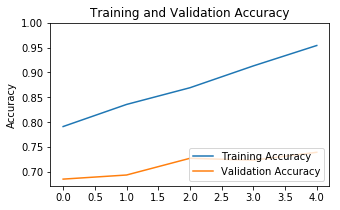

In [37]:
plt.figure(figsize=(5, 3))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.show()

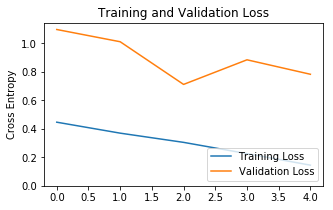

In [38]:
plt.figure(figsize=(5, 3))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

**Prediction**

In [35]:
model.load_weights('/home/ec2-user/SageMaker/resnet50_tl_mt_model-0.74.h5') #change if required

In [36]:
session = boto3.Session()
s3_session = session.client('s3')

In [37]:
def getTestImage(filename):
  #print('filename ', filename)
  f = train_dicom_dir +  filename
    
  fileobj = s3_session.get_object(Bucket=root_path,  Key=f )
  dicom_data = fileobj['Body'].read()
  dicom_bytes = DicomBytesIO(dicom_data)
  c_dicom = dcmread(dicom_bytes) 
            
  
  image = c_dicom.pixel_array
  # If grayscale. Convert to RGB for consistency.
  if len(image.shape) != 3 or image.shape[2] != 3: 
    img = np.stack((image,) * 3, -1)
 
  dim = (IMAGE_SIZE, IMAGE_SIZE)
  img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
            
  #print(' File ', f, ' img shape ', img.shape )
  img = preprocess_input(np.array(img, dtype=np.float32)) # Convert to float32 array
  return img

In [38]:
test_set = pd.DataFrame()
test_set = training_data_1.sort_values(by ='Images', ascending=False )
test_set = test_set.iloc[:3000]
test_set.reset_index(inplace= True)
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
index     3000 non-null int64
Images    3000 non-null object
Target    3000 non-null int64
dtypes: int64(2), object(1)
memory usage: 70.4+ KB


In [39]:
def predict_test(test_data_df): 

      cm_df = pd.DataFrame(columns = ['patientId', 'y_true', 'y_pred']) 
      #print ('Info ' , test_data_df.info()) 
      threshold = 0.4

      
      for ind in test_data_df.index: 
        f = test_data_df['Images'][ind]
        y_true = test_data_df['Target'][ind]
        #print ('f ', f , ' y_true ', 'y_true')
        img = getTestImage(f)
        img = np.expand_dims(img, axis=0) 
            
        results = model.predict(img)
        #print('results ', results)
        if results[0][0] >= threshold:
          y_pred = 1
        else:
          y_pred = 0
        #print ( ' patient ' , f , ' y_true ', y_true , ' y_pred ' , y_pred, ' results ', results )
        cm_df = cm_df.append ({'patientId': f, 'y_true' : y_true , 'y_pred' : y_pred}, ignore_index=True)
      return cm_df

In [40]:
cm_df = predict_test(test_set)

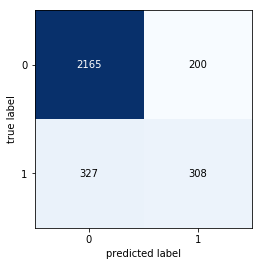

In [41]:
y_true = cm_df['y_true'].to_list()
y_pred = cm_df['y_pred'].to_list()

CM = confusion_matrix(y_true, y_pred)

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(4, 4))

plt.show()

In [46]:
from sklearn.metrics import classification_report

In [47]:
print(classification_report(y_true, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.87      0.92      0.89      2365
           1       0.61      0.49      0.54       635

    accuracy                           0.82      3000
   macro avg       0.74      0.70      0.72      3000
weighted avg       0.81      0.82      0.82      3000

